In [4]:
import glob
import time
import IPython.display as ipd
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import sklearn
import entropy
import pyACA
from pyACA.ToolComputeHann import ToolComputeHann
from pyACA.ToolReadAudio import ToolReadAudio
from entropy import spectral_entropy as spectral_entropy_feature
%matplotlib inline

# Content based features extraction

### Loading data
We load the training dataset and testing dataset.

In [5]:
data = pd.read_csv("../data/gtzan/datasets/data.csv")
data.head()

,filename,genre,genre id
0,../data/gtzan/audio/metal/metal.00099.wav,metal,6
1,../data/gtzan/audio/rock/rock.00004.wav,rock,9
2,../data/gtzan/audio/metal/metal.00078.wav,metal,6
3,../data/gtzan/audio/reggae/reggae.00060.wav,reggae,8
4,../data/gtzan/audio/country/country.00055.wav,country,2


### Data visualization
An example of a music signal from the data.

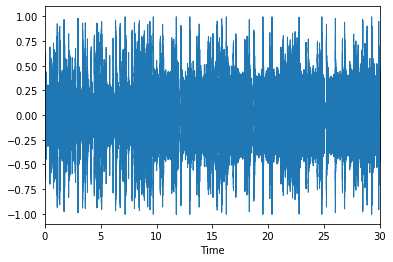

In [6]:
sample=data.iloc[0].filename
song, sr = librosa.load(sample)
plt.figure()
librosa.display.waveplot(song, sr=sr)
plt.show()

### Low-level features
Low-level features pertain to content-based features. The chosen content-based features along with their representations are listed below.
- Spectral centroid (mean + std)
- Spectral rolloff (mean + std)
- Spectral flux (mean + std)
- Spectral crest factor (mean + std)
- Spectral flatness (mean +std)
- Spectral crest (mean + std)
- Spectral decrease (mean + std)
- Spectral kurtosis (mean + std)
- Spectral slope (mean + std)
- Spectral skewness (mean + std
- Spectral contrast ( mean dimensions 7)
- spectral tonal power ratio ( mean + std)
- Spectral spread (mean + std)
- Spectral entropy
- Chroma ( mean dimensions = 12)
- Zero crossing rate (mean + std)
- Mel frequency cepstral coefficients ( mean dimensions = 52)  
- Root mean square energ (RMS mean + std)
- beat histogram ( mean + std + sum)
- Autocorrelation coefficients (mean + std)

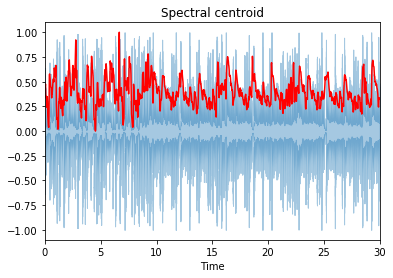

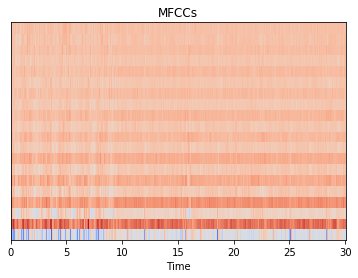

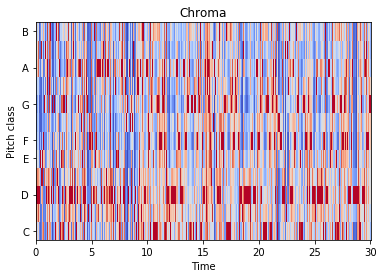

In [7]:
spectral_centroids = librosa.feature.spectral_centroid(song, sr=sr)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)# Normalising the spectral centroid for visualisation

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

plt.figure()
plt.title("Spectral centroid")
librosa.display.waveplot(song, sr=sr, alpha=0.4)
plt.plot(t,sklearn.preprocessing.minmax_scale(spectral_centroids,axis=0), color='r')

mfccs = librosa.feature.mfcc(song, sr=sr)
plt.figure()
plt.title("MFCCs")
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

hop_length = 512
chromagram = librosa.feature.chroma_stft(song, sr=sr, hop_length=hop_length)
plt.figure()
plt.title("Chroma")
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

### Audio slicing
Possibly we may want to cut audio samples into smaller segments than the default 30 seconds as means to increase amount of data we have,but currently we number_segment=1 which uses default audio segment.

In [8]:
def audio_slices(number_segments):
    sample_rate=22050
    duration=30
    samples_per_track=sample_rate*duration
    number_samples_per_segment=samples_per_track//number_segments
    audio_segments=np.zeros((number_segments,2))
    for segment in range(number_segments):
        start_sample=number_samples_per_segment*segment
        finish_sample=start_sample+number_samples_per_segment
        audio_segments[segment,:]=[start_sample,finish_sample]
        
    return audio_segments.astype(int)

### Features not covered by library functions

In [9]:
def spectral_crest_feature(wavedata,sample_rate):
    magnitude_spectrum=np.abs(librosa.stft(wavedata))
    
    norm = magnitude_spectrum.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vtsc = magnitude_spectrum.max(axis=0) / norm

    return (vtsc)

def spectral_decrease_feature(wavedata,sample_rate):
    spectrogram = librosa.feature.melspectrogram(wavedata,sample_rate)
    
    kinv = np.arange(0, spectrogram.shape[0])
    kinv[0] = 1
    kinv = 1 / kinv

    norm = spectrogram.sum(axis=0, keepdims=True)
    ind = np.argwhere(norm == 0)
    if ind.size:
        norm[norm == 0] = 1 + spectrogram[0, ind[0, 1]]  # hack because I am not sure how to sum subarrays
    norm = norm - spectrogram[0, :]

    # compute slope
    vsc = np.dot(kinv, spectrogram - spectrogram[0, :]) / norm

    return (vsc)

def spectral_spread_feature(wavedata, sr):
    x=librosa.feature.melspectrogram(wavedata,sr)
    # get spectral centroid as index
    vsc = pyACA.FeatureSpectralCentroid(x, sr) * 2 / sr * (x.shape[0] - 1)

    # X = X**2 removed for consistency with book

    norm = x.sum(axis=0)
    norm[norm == 0] = 1

    # compute spread
    vss = np.zeros(x.shape[1])
    indices = np.arange(0, x.shape[0])
    for n in range(0, x.shape[1]):
        vss[n] = np.dot((indices - vsc[0, n])**2, x[:, n]) / norm[n]

    vss = np.sqrt(vss)

    # convert from index to Hz
    vss = vss / (x.shape[0] - 1) * sr / 2

    return (vss)


### Feature extraction step

In [10]:
def low_level_features(data,number_segments=1):
    n = number_segments*len(data)
    features = ["spectral_centroid_mean","spectral_centroid_std","spectral_rolloff_mean",
              "spectral_rolloff_std","spectral_flux_mean","spectral_flux_std",
             "spectral_flatness_mean","spectral_flatness_std","spectral_crest_mean","spectral_crest_std",
             "spectral_decrease_mean","spectral_decrease_std","spectral_kurtosis_mean","spectral_kurtosis_std",
                "spectral_slope_mean","spectral_slope_std","spectral_skewness_mean","spectral_skewness_std",
                "rms_mean","rms_std","spectral_crest_factor_mean","spectral_crest_factor_std","beat_histogram_mean",
                "beat_histogram_std","zero_crossing_rate_mean","zero_crossing_rate_std","auto_corr_coeff_mean",
                "auto_corr_coeff_std","spectral_spread_mean","spectral_spread_std","spectral_entropy",
                "spectral_tonal_power_ratio_mean","spectral_tonal_power_ratio_std","beat_histogram_sum"]
    
    features_dataframe ={feature:np.zeros(n) for feature in features}
    features_dataframe["label"]=np.zeros(n).astype(int)
   
    index=0
    audio_segments=audio_slices(number_segments)
    
    for audio_index,row in data.iterrows():
        
        sr, audio = ToolReadAudio(row["filename"])
        
        for start,end in audio_segments:
            x=audio[start:end]
            
            #spectral decrease
            spectral_decrease=spectral_decrease_feature(x,sr)
            features_dataframe["spectral_decrease_mean"][index]=np.mean(spectral_decrease)
            features_dataframe["spectral_decrease_std"][index]=np.std(spectral_decrease)
            
            #spectral crest
            spectral_crest=spectral_crest_feature(x,sr)
            features_dataframe["spectral_crest_mean"][index]=np.mean(spectral_crest)
            features_dataframe["spectral_crest_std"][index]=np.std(spectral_crest)
            
            #spectral_flatness
            spectral_flatness=pyACA.computeFeature("SpectralFlatness",x,sr)[0]
            features_dataframe["spectral_flatness_mean"][index]=np.mean(spectral_flatness)
            features_dataframe["spectral_flatness_std"][index]=np.std(spectral_flatness)
            
            #spectral flux
            spectral_flux=pyACA.computeFeature("SpectralFlux",x,sr)[0]
            features_dataframe["spectral_flux_mean"][index]=np.mean(spectral_flux)
            features_dataframe["spectral_flux_std"][index]=np.std(spectral_flux)
            
            #spectral centroid
            spectral_centroid=pyACA.computeFeature("SpectralCentroid",x,sr)[0]
            features_dataframe["spectral_centroid_std"][index]=np.std(spectral_centroid)
            features_dataframe["spectral_centroid_mean"][index]=np.mean(spectral_centroid)

            #spectral rolloff
            spectral_rolloff = pyACA.computeFeature("SpectralRolloff",x,sr)[0]
            features_dataframe["spectral_rolloff_mean"][index]=np.mean(spectral_rolloff)
            features_dataframe["spectral_rolloff_std"][index]=np.std(spectral_rolloff)
            
            #spectral kurtosis
            spectral_kurtosis=pyACA.computeFeature("SpectralKurtosis",x,sr)
            features_dataframe["spectral_kurtosis_mean"][index]=np.mean(spectral_kurtosis)
            features_dataframe["spectral_kurtosis_std"][index]=np.std(spectral_kurtosis)
            
            #spectral slope
            spectral_slope=pyACA.computeFeature("SpectralSlope",x,sr)[0]
            features_dataframe["spectral_slope_mean"][index]=np.mean(spectral_slope)
            features_dataframe["spectral_slope_std"][index]=np.std(spectral_slope)
            
            #spectral skewness
            spectral_skewness=pyACA.computeFeature("SpectralSkewness",x,sr)[0]
            features_dataframe["spectral_skewness_mean"][index]=np.mean(spectral_skewness)
            features_dataframe["spectral_skewness_std"][index]=np.std(spectral_skewness)
            
            #spectral crest factor
            spectral_crest_factor=pyACA.computeFeature("SpectralCrestFactor",song,sr)[0]
            features_dataframe["spectral_crest_factor_mean"][index]=np.mean(spectral_crest_factor)
            features_dataframe["spectral_crest_factor_std"][index]=np.std(spectral_crest_factor)
            
            #spectral spread
            spectral_spread=spectral_spread_feature(x,sr)
            features_dataframe["spectral_spread_mean"][index]=np.mean(spectral_spread)
            features_dataframe["spectral_spread_std"][index]=np.std(spectral_spread)
            
            #spectral_tonal_power_ratio
            spectral_tonal_power_ratio=pyACA.computeFeature("SpectralTonalPowerRatio",song,sr)[0]
            features_dataframe["spectral_tonal_power_ratio_mean"][index]=np.mean(spectral_tonal_power_ratio)
            features_dataframe["spectral_tonal_power_ratio_std"][index]=np.std(spectral_tonal_power_ratio)
            
            #spectral_entropy
            spectral_entropy=spectral_entropy_feature(x, sr, method='fft')
            features_dataframe["spectral_entropy"][index]=spectral_entropy
            
            #beat histogram
            beat_histogram=pyACA.computeBeatHisto(x,sr)[0]
            features_dataframe["beat_histogram_mean"][index]=np.mean(beat_histogram)
            features_dataframe["beat_histogram_std"][index]=np.std(beat_histogram)
            features_dataframe["beat_histogram_sum"][index]=np.sum(beat_histogram)
            
            #autocorrelation coefficients
            auto_correlation_coefficients=pyACA.computeFeature("TimeAcfCoeff",x,sr)[0]
            features_dataframe["auto_corr_coeff_mean"][index]=np.mean(auto_correlation_coefficients)
            features_dataframe["auto_corr_coeff_std"][index]=np.std(auto_correlation_coefficients)
            
            #chroma
            chroma=pyACA.computeFeature("SpectralPitchChroma",x,sr)[0]
            chroma=np.mean(chroma,axis=1)

            for i in range(len(chroma)):
                key="chroma"+str(i+1)
                if key in features_dataframe.keys():
                    features_dataframe[key][index]=(chroma[i])
                else:
                    features_dataframe[key]=np.zeros(n)
                    features_dataframe[key][index]=(chroma[i])

            #extract zero crossing rate
            zcr=pyACA.computeFeature("TimeZeroCrossingRate",x,sr)[0]
            features_dataframe["zero_crossing_rate_mean"][index]=(np.mean(zcr))
            features_dataframe["zero_crossing_rate_std"][index]=(np.std(zcr))
            
            #extract root mean square energy
            rms=librosa.feature.rms(x)
            features_dataframe["rms_mean"][index]=np.mean(rms)
            features_dataframe["rms_std"][index]=np.std(rms)

            #mfccs
            mfccs=librosa.feature.mfcc(x,sr=sr,n_mfcc=52)
            mfccs=np.mean(mfccs,axis=1)

            for i in range(len(mfccs)):
                key="mfcc"+str(i+1)
                if key in features_dataframe.keys():
                    features_dataframe[key][index]=(mfccs[i])
                else:
                    features_dataframe[key]=np.zeros(n)
                    features_dataframe[key][index]=(mfccs[i])

            #spectral contrast
            spectral_contrast = librosa.feature.spectral_contrast(x, sr=sr)
            spectral_contrast = np.mean(spectral_contrast,axis=1)

            for i in range(len(spectral_contrast)):
                key="spectral_contrast"+str(i+1)
                if key in features_dataframe.keys():
                    features_dataframe[key][index]=(spectral_contrast[i])
                else:
                    features_dataframe[key]=np.zeros(n)
                    features_dataframe[key][index]=(spectral_contrast[i])
            
            features_dataframe["label"][index]=data["genre id"].values[audio_index]
            index=index+1

    features_dataframe=pd.DataFrame(features_dataframe)
    return features_dataframe

In [ ]:
start = time.time()
features = low_level_features(data)
features.to_csv("../data/GTZAN/features/features.csv",index=False)
end=time.time()
print("Feature extraction duration :",end-start)
features.head()